In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
#Changing the font of plots;
plt.rc('font', family='serif')

# Constants

In [2]:
'''
   Data Description in Appendix1 page 416-420
   The transformation codes are:
   1:no transformation
   2:first difference
   4:logarithm
   5:first difference of logarithm.
   An asterisk *, next to the mnemonic, denotes a variable assumed 
   to be slow-moving in the estimation
'''

# Let us keep the indexes of the slow-moving variables
list_slowindex = list(range(0,53))+list(range(102,119))         
list_xindex    = [15,107,77,80,95,92,73,101,16,48,50,25,47,117,53,61,70,119] 
dict_data      = {0:'IPP',
                  1:'IPF',
                  2:'IPC',
                  3:'IPCD',
                  4:'IPCN'}

# Functions

In [3]:
def extract_svd(x,nf):
    '''
    Compute the factors with the SVD
    
    Inputs
        x : the data
        nf: number of factors
             
     Outputs
         lam: the factor loadings
         fac: the factors    
    '''
    
    U, s, V = LA.svd(x.values)
    W       = V.T[:,:nf]
    lam     = W*np.sqrt(x.shape[1])
    fac     = x.values@lam/x.shape[1]
    
    return fac, lam 

In [4]:
def facrot(F,Ffast,Fslow, n_factors):
    '''
    Computes the rotation of the factors as described in p.405 of the paper
    
    Inputs
        F    : unrestricted PC estimates (from all the dataset)
        Ffast: factors assumed to be fast moving (e.g. policy instrument)
        Fslow: proxy of the slow moving factors
    
    Outputs
        Fr: rotation of factors
    '''

    F, Fslow, Ffast = [np.array(i) for i in [F, Fslow, Ffast]]
    Fslow           = np.hstack([Fslow, Ffast])
    betas           = LA.inv(Fslow.T@Fslow)@Fslow.T@F
    Fr              = F - np.dot(Ffast,betas[n_factors:,:])
    
    return pd.DataFrame(Fr)

In [5]:
def extract_fac(x,Y,K,slowindex, n_factors):
    # Routine to extract the factors
    # 1. Extract factors from whole dataset F
    # 2. Extract factors from slow moving dataset Fslow
    # 3. Regress factors F on Flsow and Y and subtract effect of Y from F to obtain Fr
    
    x              =  pd.DataFrame(x)
    xslow          = x.loc[:,x.columns[slowindex]]
    F,Lf           = extract_svd(x,K)
    Fslow , Lfslow = extract_svd(xslow,K)
    Fr             = facrot(F,Y,Fslow, n_factors)
    
    return Fr

In [6]:
def shuffle(x,new_index):
    # Reshufle index of a variable (here a DataFrame)
    
    T         = x.shape[0]
    x_s       = np.zeros(x.shape)
    for ii in range(0,T):
        x_s[ii,:] = x.iloc[new_index[ii],:]
    return x_s    

In [7]:
def simulate(X,e,num_vars,num_lags,num_obs,A0,bhat,i2):
    
    T_var = num_obs - num_lags
    X_sim = np.zeros([num_vars,num_lags])
    
    for lag in range(num_lags):
        X_sim[:,num_lags-lag-1] = X.iloc[lag,:]
    X_sim   = np.reshape(X_sim,(num_lags*num_vars,1),order='F')
    X_sim   = np.hstack((X_sim,np.zeros([num_lags*num_vars,num_obs-1])))        
    D       = np.vstack((A0,np.zeros([(num_lags-1)*num_vars,num_vars])))
    c_b = np.vstack((bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 
    
    for t in range(T_var-1):
        X_sim[:,t+num_lags+1]   = c_b@X_sim[:,t+num_lags] + D@e.T[:,np.int(i2[t])]
            
    X_sim      = X_sim[:num_vars,:].T
    return X_sim

In [8]:
def lags(X,num_lags):
    # routine to lag a series or a dataset
    lfy = pd.DataFrame()
    fy  = pd.DataFrame(X)
    for i in range(1,num_lags+1):
        lfy = pd.concat([lfy,fy.shift(i).add_suffix("-"+str(i))],axis=1)
    fyr  = np.array(fy.iloc[num_lags:,:])
    lfyr = np.array(lfy.iloc[num_lags:,:])
    return fyr,lfyr

In [9]:
def identific(Omegahat):
    #routine to perform the cholesky identification
    smatr = LA.cholesky(Omegahat)
    d = np.zeros(smatr.shape)
    np.fill_diagonal(d,np.diag(smatr))
    smatr = LA.inv(d)@smatr
    return smatr


In [10]:
def impulses(num_impulses,num_vars,shock,bhat,A0, num_lags):
    IRF  = np.zeros([num_impulses,num_vars,num_vars])
    c_br = np.vstack((bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 
    Temp = np.identity(c_br.shape[0])
    psi  = []
    for t in range(num_impulses):
        psi_t = Temp[:num_vars,:num_vars] 
        IRF[t,:,:] = psi_t@A0  # store the IRF
        Temp = c_br@Temp            # computes the exponent of the matrix
    IRFr   = IRF@shock    
    irfr   = pd.DataFrame({i:IRFr[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
    return irfr

In [11]:
def Bands(num_impulses, M, K, nrep1, nrep2, xir, Y, u0, F0, Lf0, slowindex, 
          num_factors, num_lags, num_vars, num_obs, shock, xindex):
    '''
    LOOP to COMPUTE the Confidence Intervals using bootsrapping
    '''
    
    # Containers of the IRF
    imp  = np.zeros([num_impulses*(M+K),nrep1*nrep2])
    impx = np.zeros([num_impulses*xir.shape[1],nrep1*nrep2])
    
    #main loop
    repetition=0
    for frep in range(0,nrep1):
        # this loop appears to be less important it was designed to bootstrap the estimates coming from the factors extraction
        T_data = Y.shape[0]
        
        # create the new index to reorder the osbervations randomly
        i      = (T_data-1)*np.random.rand(T_data,1)
        i      = np.round(i)
        
        # reorder the residuals of the X_t = LAMBDA*F_t + u_t
        u_star    = shuffle(u0,i) # u_star_t is reordererd u_t
        
        # build a new dataset X_star_t = LAMBDA*F_t + u_star_t
        x_star    = F0@Lf0.T+ u_star
        
        # get the factors from the new dataset
        Fr_star   = extract_fac(x_star,Y,K,slowindex, num_factors)
        
        # build the VAR data
        fy        = np.hstack([Fr_star, Y])
        
        # keep the OLS coef of the (original) variables to the VAR variables(xir is a subsample we are interestd in)
        # X_t = beta*Y_t + e_t 
        
        bx        = LA.inv(fy.T@fy)@fy.T@xir
        ex        = xir - fy@bx
        
        # Estimate the VAR with the new VAR data 
        fy2,lfy2  = lags(fy,num_lags)
        bhat      = LA.inv(lfy2.T@lfy2)@lfy2.T@fy2
        eps       = fy2-lfy2@bhat
        
        # keep the number of observations in the VAR
        T_var     = fy2.shape[0]
        k_var     = fy2.shape[1]
        p         = np.int((lfy2.shape[1]-1)/k_var)
        
        btilda    = bhat
        bxtilda   = bx
        
        for rep in range(1,nrep2):
            # this loop computes the IRF
            
            repetition = repetition+1
            # new index for the bootsrap
            i2         = (T_var-1)*np.random.rand(T_var,1)
            i2         = np.round(i2)
           
            Xr         = pd.DataFrame(fy)
            # randomly select intial values for the lags
            i3         = (T_data-1)*np.random.rand(T_data,1)
            i3         = np.round(i3)
            Xr         = shuffle(Xr,i3)
            Xr         = pd.DataFrame(Xr)
            
            # SIMULATE THE NEW TIME SERIES Y = B*Y(-1) + u(reshufled)
            X_sim      = simulate(Xr,eps,num_vars,num_lags,num_obs,np.eye(num_vars),btilda,i2)
            
            # Compute the Xir_star_t = beta*Y_star_t + e_t         
            ex2        = shuffle(ex,i3)    
            xr2        = X_sim@bxtilda + ex2
            bxr        = LA.inv(X_sim.T@X_sim)@X_sim.T@xr2
            
            # Estimate the VAR
            fyr,lfyr   = lags(X_sim,num_lags)
            br         = LA.inv(lfyr.T@lfyr)@lfyr.T@fyr
            er         = fyr - lfyr@br
            Omegahatr  = er.T@er/(er.shape[0]-p*k_var-1)
            
            # indentify the SVAR
            A0r      = identific(Omegahatr)
            # compute the IRF
            irfr       = impulses(num_impulses,num_vars,shock,br,A0r, num_lags)
            impr       = np.array(irfr)
            impxr      = np.array(impr@bxr)
            
            # STORE THE IRFS 
            imp[:,repetition-1]  = np.reshape(impr,(num_impulses*(1+num_factors),1)).flatten()
            impx[:,repetition-1] = np.reshape(impxr,((num_impulses*len(xindex)),1)).flatten()
    
    # KEEP THE 5% - 95% IRF sorted 
    imp    = imp.reshape(num_impulses,M+K,nrep1*nrep2)
    impx   = impx.reshape(num_impulses,len(xindex),nrep1*nrep2)
    imp    = np.sort(imp,axis=2)
    impx   = np.sort(impx,axis=2)
    nrep   = nrep1*nrep2
    impci  = imp[:,:,[np.int(0.05*nrep),np.int(0.95*nrep)]]
    impxci = impx[:,:,[np.int(0.05*nrep),np.int(0.95*nrep)]]
    
    return impxci

In [12]:
def BBE(source, σ_multiplier, n_factors):
    '''
    Simulate BBE with two input paramaters.
    
    Input
        source      : str data
        σ_multiplier: int/float
        n_factors   : int
    
    Output 
        irf  : impulse 
        irf_x: impulse in x
    
    '''
    
    ''' Transforming the data '''
    df_data = pd.read_csv(source, header=None)
    σ_ffr   = df_data.loc[:,76].std()*σ_multiplier
    df_tran = df_data.apply(lambda x: (x-x.mean())/x.std())
    
    ''' Specification: what is observable '''
    observables = [76]        #["ffr"]
    Y = df_tran.loc[:,observables]
    X = df_tran.loc[:,df_tran.columns.difference(observables)]
    
    ''' Parameters '''
    T, N               = X.shape     # n of observations and series
    M                  = Y.shape[1]  # n of series considered observables factors
    K                  = n_factors
    n_impulses, n_lags = 40, 13
    n_rep1, n_rep2     = 1, 100
    nsteps             = 48
    
    ''' Setup '''
    F0, Lf0         = extract_svd(X,K)
    xslow           = df_tran.loc[:,df_tran.columns[list_slowindex]]
    Fslow0, Lfslow0 = extract_svd(xslow,K)
    Fr0             = facrot(F0,Y,Fslow0, n_factors)
    u0              = X -F0@Lf0.T
    X               = pd.concat([Fr0, Y],axis=1)
    XLAG            = pd.DataFrame()
    for i in range(1,n_lags+1):
        XLAG        = pd.concat([XLAG,X.shift(i).add_suffix(f"-{i}")],axis=1)
        
    ''' Renaming '''
    X2     = X.iloc[n_lags:,:]
    XLAG2  = XLAG.iloc[n_lags:,:]
    n_vars = X2.shape[1]
    n_obs  = XLAG2.shape[0]
    X3     = np.array(X2)
    XLAG3  = np.array(XLAG2)
    
    ''' Estimation '''
    #VAR - standard OLS
    β̂     = LA.inv(XLAG3.T@XLAG3)@XLAG3.T@X3
    #Estimated errors
    ε     = (X3 - XLAG3@β̂ )
    n_obs = T
    # Estimated covariance matrix
    Ω̂     = ε.T@ε/(T-n_lags*n_vars-1)
    # Cannonical Form
    c_β̂   = np.vstack((β̂ .T,np.hstack((np.identity((n_lags-1)*n_vars),
                                        np.zeros([(n_lags-1)*n_vars,n_vars])))))
    
    ''' Identification '''
    A0                         = LA.cholesky(Ω̂ )
    d                          = np.zeros(A0.shape)
    d[np.diag_indices_from(d)] = np.diag(A0)
    A0                         = np.dot(np.linalg.inv(d),A0)
    
    ''' IRFs '''
    # IRFs are stored in a 3-dimensional array. 
    # Dimension 1 is time, 2 is variable, and 3 is shock. 
    IRF            = np.zeros([n_impulses,n_vars,n_vars])
    temp           = np.identity(c_β̂ .shape[0])
    ψ              = []
    for t in range(n_impulses):
        ψ_t        = temp[:n_vars,:n_vars]
        # store the IRF
        IRF[t,:,:] = ψ_t@A0     
        # computes the exponent of the matrix
        temp       = c_β̂ @temp 
    
    ''' Shocks '''
    shock = np.hstack([np.zeros([1,K+M-1]), np.ones([1,1])*0.25/σ_ffr]).T
    IRF   = IRF@shock    
    irf   = pd.DataFrame({i:IRF[i].flatten() for i in range(n_impulses)}).T
    
    ''' Recovering the shocks '''
    xir   = df_tran.loc[:,df_tran.columns[list_xindex]]
    bx0   = LA.inv(X.T@X)@X.T@xir
    irf_x = irf@bx0
    
    ''' Confidence Intervals using bootsrapping '''
    impxci = Bands(n_impulses, M, K, n_rep1, n_rep2, xir, Y, u0, F0, Lf0, 
                   list_slowindex,n_factors, n_lags, n_vars, n_obs, 
                   shock, list_xindex)
    
    return irf, irf_x, impxci

In [13]:
def graphs(irfs, irfs_new, legend_new):
    '''
    Plot the IRFs
    '''
    
    f, axes = plt.subplots(ncols=1, nrows=3, figsize=(6,9), dpi=100); axes = axes.flatten()
    
    for j, array in enumerate([irfs, irfs_new]):
        axes[0].plot(np.exp(np.cumsum(array[1][15]))-1, c=['k','grey'][j], linestyle="-")
        axes[1].plot(np.exp(np.cumsum(array[1][107]))-1, c=['k','grey'][j], linestyle="-")
        axes[2].plot(array[0][3],c=['k','grey'][j], linestyle="-")
        
    for i in range(3): 
        axes[i].set_title(['IP', 'CPI', 'MP shock'][i])
        axes[i].grid(); axes[i].set_xlabel('Period'); axes[i].legend(['Original', legend_new])
    
    for j, array in enumerate([irfs, irfs_new]):
        for band in range(2):
            axes[0].plot(np.exp(np.cumsum(array[2][:,0,band]))-1, c=['k','grey'][j],linestyle=':')
            axes[1].plot(np.exp(np.cumsum(array[2][:,1,band]))-1, c=['k','grey'][j],linestyle=':')

    
    plt.tight_layout()

<br>

# Execution

In [14]:
irf, irf_x, impxci          = BBE(source='nsbalpanel.csv', σ_multiplier=1, n_factors=3)
irf_23, irf_x_23, impxci_23 = BBE(source='nsbalpanel.csv', σ_multiplier=2, n_factors=3)
irf_14, irf_x_14, impxci_14 = BBE(source='nsbalpanel.csv', σ_multiplier=1, n_factors=4)
irf_15, irf_x_15, impxci_15 = BBE(source='nsbalpanel.csv', σ_multiplier=1, n_factors=5)

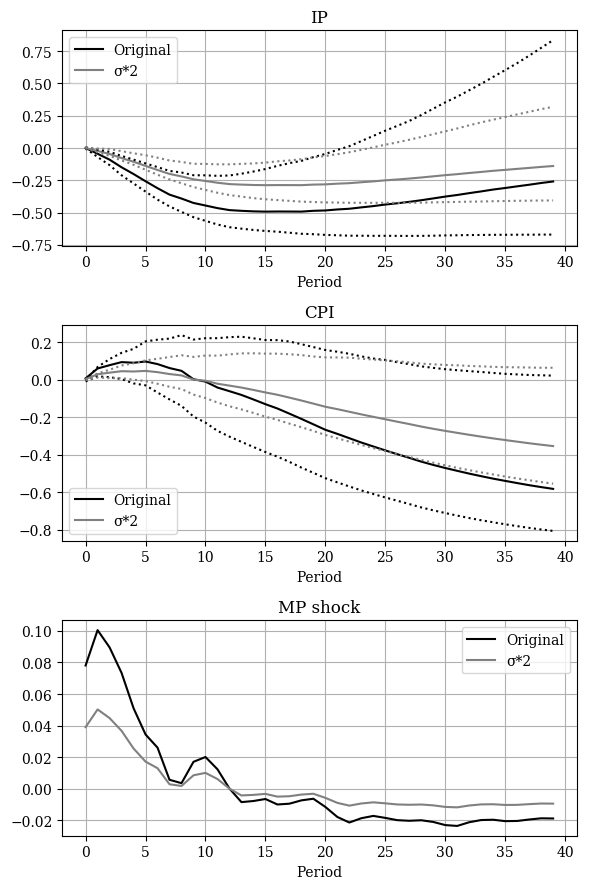

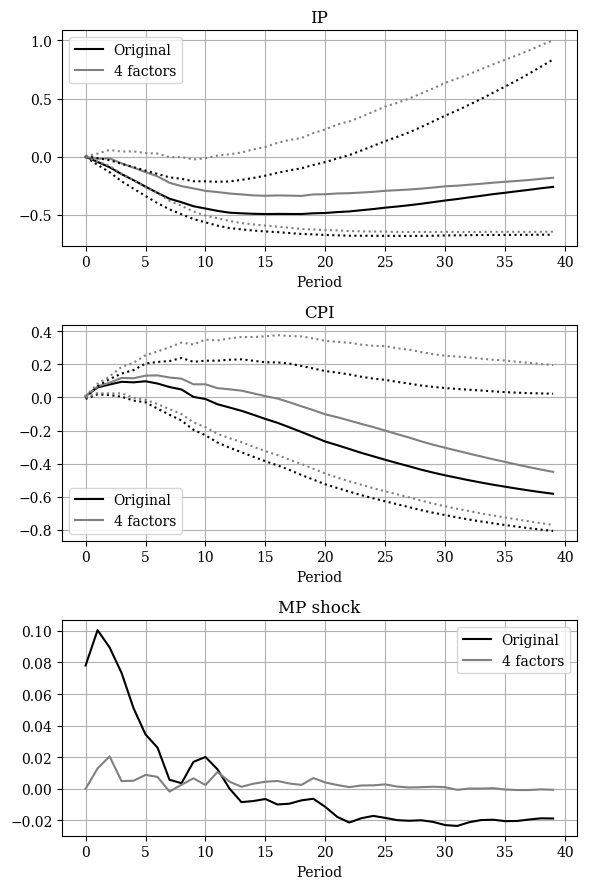

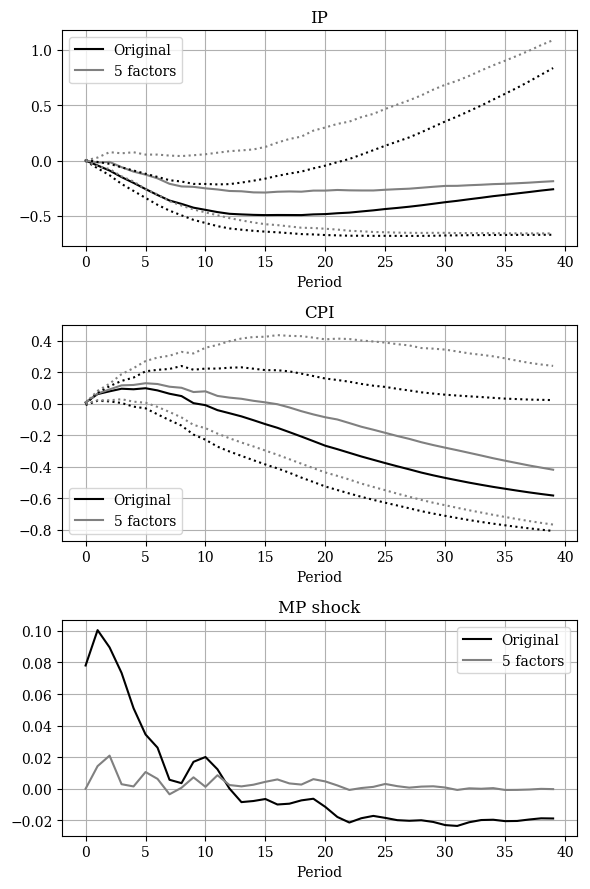

In [15]:
graphs([irf, irf_x, impxci], [irf_23, irf_x_23, impxci_23], 'σ*2')
graphs([irf, irf_x, impxci], [irf_14, irf_x_14, impxci_14], '4 factors')
graphs([irf, irf_x, impxci], [irf_15, irf_x_15, impxci_15], '5 factors')

<br>